## IOI with Masked Interventions

In [ ]:
__author__ = "Zhengxuan Wu"
__version__ = "01/31/2024"

### Overview

This tutorial analyzes the IOI task with a new type of trainable intervention, masked interchange intervention

### Set-up

In [ ]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [1]:
import sys
sys.path.append("../..")

In [2]:
import random
import pandas as pd
from tutorial_ioi_utils import *
import pyvene as pv

import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
    scale_y_reverse,
    scale_fill_cmap,
    geom_text,
    scale_fill_gradient,
    geom_point,
    geom_line,
    theme_minimal,
    ylim,
    ggtitle,
    ggsave,
    labs,
    scale_x_discrete,
    geom_histogram,
    scale_fill_manual,
)

# please try not to do this, the plot somehow throw warnings though :(
import warnings

warnings.filterwarnings("ignore")

config, tokenizer, gpt2 = pv.create_gpt2_lm()
_ = gpt2.eval().to("cuda")

loaded model


In [50]:
train_distribution = PromptDistribution(
    names=NAMES[: len(NAMES) // 2],
    objects=OBJECTS[: len(OBJECTS) // 2],
    places=PLACES[: len(PLACES) // 2],
    prefix_len=2,
    prefixes=PREFIXES,
    templates=TEMPLATES[:2],
)

test_distribution = PromptDistribution(
    names=NAMES[len(NAMES) // 2 :],
    objects=OBJECTS[len(OBJECTS) // 2 :],
    places=PLACES[len(PLACES) // 2 :],
    prefix_len=2,
    prefixes=PREFIXES,
    templates=TEMPLATES[2:],
)

aligning_variable = "position"
aligning_stream = "block_output"
aligning_pos = 17
aligning_layer = 8

batch_size = 20
eval_every = 5
initial_lr = 1e-4
n_epochs = 50

if aligning_variable == "name":
    # we hacky the distribution a little
    train_distribution = PromptDistribution(
        names=NAMES[:20],
        objects=OBJECTS[: len(OBJECTS) // 2],
        places=PLACES[: len(PLACES) // 2],
        prefix_len=2,
        prefixes=PREFIXES,
        templates=TEMPLATES[:2],
    )

    test_distribution = PromptDistribution(
        names=NAMES[:20],
        objects=OBJECTS[len(OBJECTS) // 2 :],
        places=PLACES[len(PLACES) // 2 :],
        prefix_len=2,
        prefixes=PREFIXES,
        templates=TEMPLATES[2:],
    )
else:
    train_distribution = PromptDistribution(
        names=NAMES[: len(NAMES) // 2],
        objects=OBJECTS[: len(OBJECTS) // 2],
        places=PLACES[: len(PLACES) // 2],
        prefix_len=2,
        prefixes=PREFIXES,
        templates=TEMPLATES[:2],
    )

    test_distribution = PromptDistribution(
        names=NAMES[len(NAMES) // 2 :],
        objects=OBJECTS[len(OBJECTS) // 2 :],
        places=PLACES[len(PLACES) // 2 :],
        prefix_len=2,
        prefixes=PREFIXES,
        templates=TEMPLATES[2:],
    )

D_train = train_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=["ABB", "BAB"],
    source_patterns=["ABB", "BAB"]
    if aligning_variable == "position"
    else ["CDD", "DCD"],
    labels=aligning_variable,
    samples_per_combination=50 if aligning_variable == "position" else 50,
)
D_test = test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=[
        "ABB",
    ],
    source_patterns=["BAB"] if aligning_variable == "position" else ["DCD"],
    labels=aligning_variable,
    samples_per_combination=50,
) + test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=[
        "BAB",
    ],
    source_patterns=["ABB"] if aligning_variable == "position" else ["CDD"],
    labels=aligning_variable,
    samples_per_combination=50,
)


In [51]:
def calculate_loss_with_mask(logits, labels, intervenable, coeff=1):
    loss = calculate_loss(logits, labels)
    for k, v in intervenable.interventions.items():
        mask_loss = coeff * torch.norm(v[0].mask, 1)
    loss += mask_loss
    return loss

config = pv.IntervenableConfig({
    "component": aligning_stream, "layer": aligning_layer,
    "intervention_type": pv.SigmoidMaskIntervention,
    },
)
pv_gpt2 = pv.IntervenableModel(config, gpt2)
pv_gpt2.set_device("cuda")
pv_gpt2.disable_model_gradients()

total_step = 0
optimizer = torch.optim.Adam(
    pv_gpt2.get_trainable_parameters(), lr=initial_lr
)
target_total_step = int(len(D_train) / batch_size) * n_epochs
temperature_start = 1e-2
temperature_end = 1e-7
temperature_schedule = (
    torch.linspace(
        temperature_start, temperature_end, target_total_step
    ).to(torch.bfloat16).to("cuda")
)
pv_gpt2.set_temperature(temperature_schedule[total_step])
scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, end_factor=0.1, total_iters=n_epochs
)

for epoch in tqdm(range(n_epochs)):
    torch.cuda.empty_cache()
    for batch_dataset in D_train.batches(batch_size=batch_size):
        # prepare base
        base_inputs = batch_dataset.base.tokens
        b_s = base_inputs["input_ids"].shape[0]
        for k, v in base_inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                base_inputs[k] = v.to(gpt2.device)
        # prepare source
        source_inputs = batch_dataset.source.tokens
        for k, v in source_inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                source_inputs[k] = v.to(gpt2.device)
        # prepare label
        labels = batch_dataset.patched_answer_tokens[:, 0].to(
            gpt2.device
        )

        assert all(x == 18 for x in batch_dataset.base.lengths)
        assert all(x == 18 for x in batch_dataset.source.lengths)
        _, counterfactual_outputs = pv_gpt2(
            {"input_ids": base_inputs["input_ids"]},
            [{"input_ids": source_inputs["input_ids"]}],
            {
                "sources->base": aligning_pos
            },
        )
        eval_metrics = compute_metrics(
            [counterfactual_outputs.logits], [labels]
        )
        loss = calculate_loss_with_mask(
            counterfactual_outputs.logits, labels, pv_gpt2
        )
        loss_str = round(loss.item(), 2)
        loss.backward()
        optimizer.step()
        scheduler.step()
        pv_gpt2.set_zero_grad()
        pv_gpt2.set_temperature(
            temperature_schedule[total_step]
        )
        total_step += 1
        
# eval
eval_labels = []
eval_preds = []
with torch.no_grad():
    torch.cuda.empty_cache()
    for batch_dataset in D_test.batches(batch_size=batch_size):
        # prepare base
        base_inputs = batch_dataset.base.tokens
        b_s = base_inputs["input_ids"].shape[0]
        for k, v in base_inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                base_inputs[k] = v.to(gpt2.device)
        # prepare source
        source_inputs = batch_dataset.source.tokens
        for k, v in source_inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                source_inputs[k] = v.to(gpt2.device)
        # prepare label
        labels = batch_dataset.patched_answer_tokens[:, 0].to(gpt2.device)

        assert all(x == 18 for x in batch_dataset.base.lengths)
        assert all(x == 18 for x in batch_dataset.source.lengths)
        _, counterfactual_outputs = pv_gpt2(
            {"input_ids": base_inputs["input_ids"]},
            [{"input_ids": source_inputs["input_ids"]}],
            {
                "sources->base": aligning_pos
            },
        )
        eval_labels += [labels]
        eval_preds += [counterfactual_outputs.logits]
eval_metrics = compute_metrics(eval_preds, eval_labels)
for k, v in pv_gpt2.interventions.items():
    mask = v[0].mask
    temperature = v[0].temperature
    break
print(eval_metrics)
print(
    "bits turned on: ", 
    torch.sigmoid(mask / torch.tensor(temperature)).sum()
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.78it/s]

{'accuracy': 0.58, 'kl_div': tensor(-77.9607, device='cuda:0')}
bits turned on:  tensor(534.7392, device='cuda:0', grad_fn=<SumBackward0>)


In [52]:
bit_map = torch.sigmoid(mask / torch.tensor(temperature)).tolist()

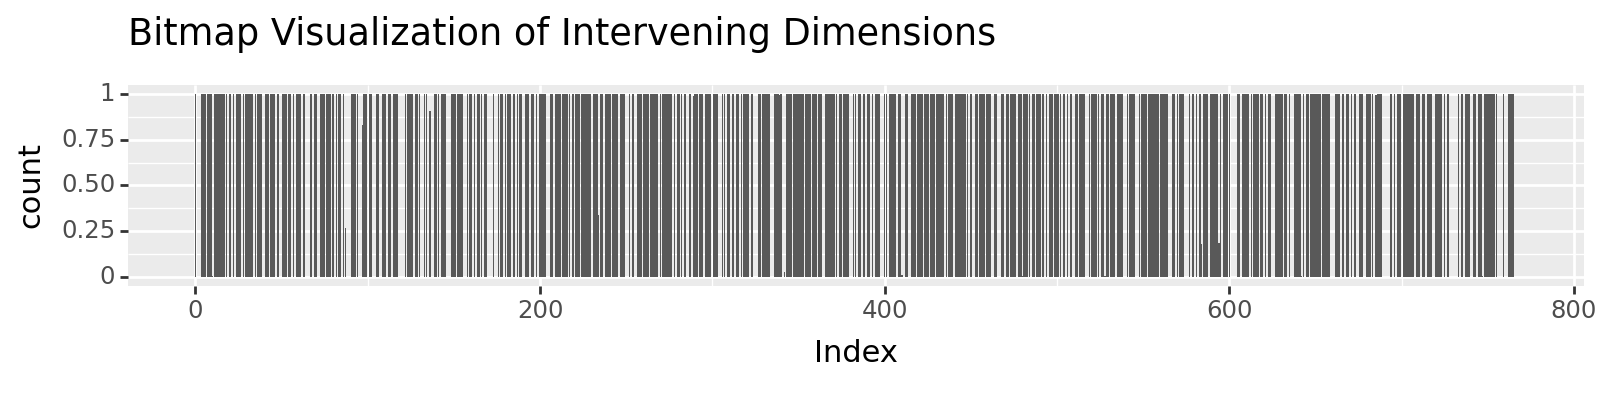

In [53]:
# Convert the list to a DataFrame
df = pd.DataFrame({'Value': bit_map, 'Index': range(len(bit_map))})

# Create a barplot
plot = ggplot(df, aes(x='Index', weight='Value')) + geom_bar() + \
       ggtitle('Bitmap Visualization of Intervening Dimensions') + \
       theme(figure_size=(8,2))

print(plot)